# Решающие деревья
### AI Community: Практический курс по машинному обучению
#### Материалы подготовлены EORA Data Lab

## Решающее дерево
Решающее дерево (дерево решений) $-$ это функция от объекта в его признаковом описании. Ее значение вычисляется путем прохода некоторого дерева от корня к листу. Переход по дереву происходит путем принятия решения в узле дерева. 

<img src="./images/CART_tree_titanic_survivors.png" alt="Drawing" style="height: 300px;"/>

За счет такого представления результат дерева возможно проинтерпретировать. Например, согласно дереву выше значение `Survived` принимается согласно логическому условию: `Sex == "female" | ((Age > 9.5) & (Sibsp > 25))`.

In [2]:
# !conda install -c conda-forge graphviz -y
# !conda install -c anaconda pydotplus -y

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Vyacheslav\Anaconda\envs\training_pipeline

  added / updated specs:
    - graphviz





==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda





The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1h             |       he774522_0         5.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.8 MB

The following packages will be UPDATED:

  openssl               anaconda::openssl-1.1.1g-he774522_1 --> conda-forge::openssl-1.1.1h-he774522_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates     anaconda::ca-certificates-2020.7.22-0 --> conda-forge::ca-certificates-2020.6.20-hecda079_0
  certifi                anaconda::certifi-2020.6.20-py37_0 --> conda-forge::certifi-2020.6.20-py37hc8dfbb8_0




openssl-1.1.1h       | 5.8 MB    |            |   0% 
openssl-1.1.1h       | 5.8 MB    |            |   0% 
openssl-1.1.1h       | 5.8 MB    | 1          |   2% 
openssl-1.1.1h       | 5.8 MB    | 3  



==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda





Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Vyacheslav\Anaconda\envs\training_pipeline

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1h             |       he774522_0         5.8 MB  anaconda
    pydotplus-2.0.2            |             py_3          23 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.8 MB

The following NEW packages will be INSTALLED:

  pydotplus          anaconda/noarch::pydotplus-2.0.2-py_3

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.6.2~ --> anaconda::ca-certificates-2020.7.22-0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2020.6.20-py37hc~ --> anaconda::c

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

# Для отрисовки деревьев
import pydotplus
from IPython.display import Image

openssl-1.1.1h       | 5.8 MB    | ########3  |  83% 
openssl-1.1.1h       | 5.8 MB    | ########5  |  85% 
openssl-1.1.1h       | 5.8 MB    | ########6  |  87% 
openssl-1.1.1h       | 5.8 MB    | ########8  |  88% 
openssl-1.1.1h       | 5.8 MB    | ########9  |  90% 
openssl-1.1.1h       | 5.8 MB    | #########1 |  92% 
openssl-1.1.1h       | 5.8 MB    | #########3 |  93% 
openssl-1.1.1h       | 5.8 MB    | #########4 |  95% 
openssl-1.1.1h       | 5.8 MB    | #########6 |  96% 
openssl-1.1.1h       | 5.8 MB    | #########8 |  98% 
openssl-1.1.1h       | 5.8 MB    | #########9 | 100% 
openssl-1.1.1h       | 5.8 MB    | ########## | 100% 

pydotplus-2.0.2      | 23 KB     |            |   0% 
pydotplus-2.0.2      | 23 KB     | ######8    |  68% 
pydotplus-2.0.2      | 23 KB     | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


Давайте попробуем классифицировать точки на плоскости.

In [4]:
n_points = 2000
x = np.vstack([np.random.normal(loc=1, size=(n_points, 2)),
               np.random.normal(loc=-1, size=(n_points, 2))])
y = np.array([0] * n_points + [1] * n_points)

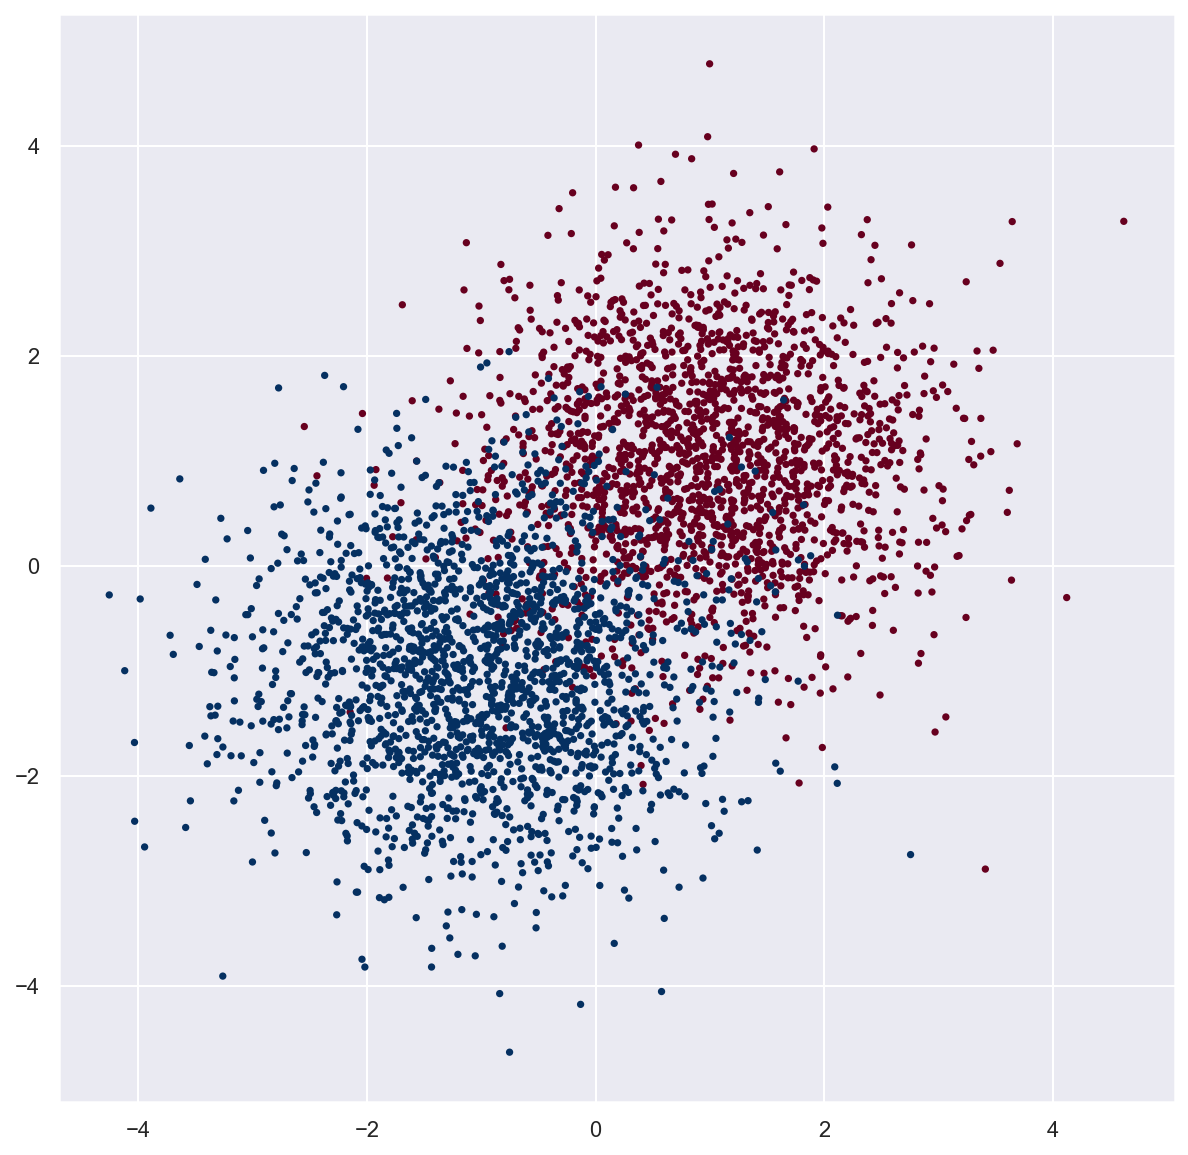

In [5]:
plt.figure(figsize=(10.0, 10.0))
plt.scatter(x[:, 0], x[:, 1], c=y, s=7, cmap=plt.cm.RdBu);

Следующие функции рисуют разделяющую поверхность модели и структуру дерева.

In [6]:
def plot_predictions(X, y, clf, proba=False, points_size=7):
    """Fits the classifier on the data (X, y) and plots the result on a 2-D plane."""
    def get_grid(data):
        x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
        y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
        return np.meshgrid(np.arange(x_min, x_max, 0.01),
                           np.arange(y_min, y_max, 0.01))
    
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10.0, 10.0))
    plt.pcolormesh(xx, yy, predicted, cmap=plt.cm.RdBu, alpha=0.1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=points_size, cmap=plt.cm.RdBu, alpha=0.90)
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.xlabel('x')
    plt.ylabel('y')
    
    return clf

def plot_tree(model, features, max_depth, out_file='tree.tmp'):
    dot_data = export_graphviz(decision_tree=model, out_file=out_file,
                               max_depth=max_depth, feature_names=features,
                               class_names=['0', '1'], filled=True, rounded=True,
                               special_characters=True,
                               proportion = True, precision=2,
                               label='all', impurity=False)  

    graph = pydotplus.graphviz.graph_from_dot_file(out_file)  
    return Image(graph.create_png())

Обучим дерево и посмотрим на него.

In [7]:
from sklearn.linear_model import LogisticRegression

D:\Vyacheslav\Anaconda\envs\training_pipeline\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


LogisticRegression(C=0.001)

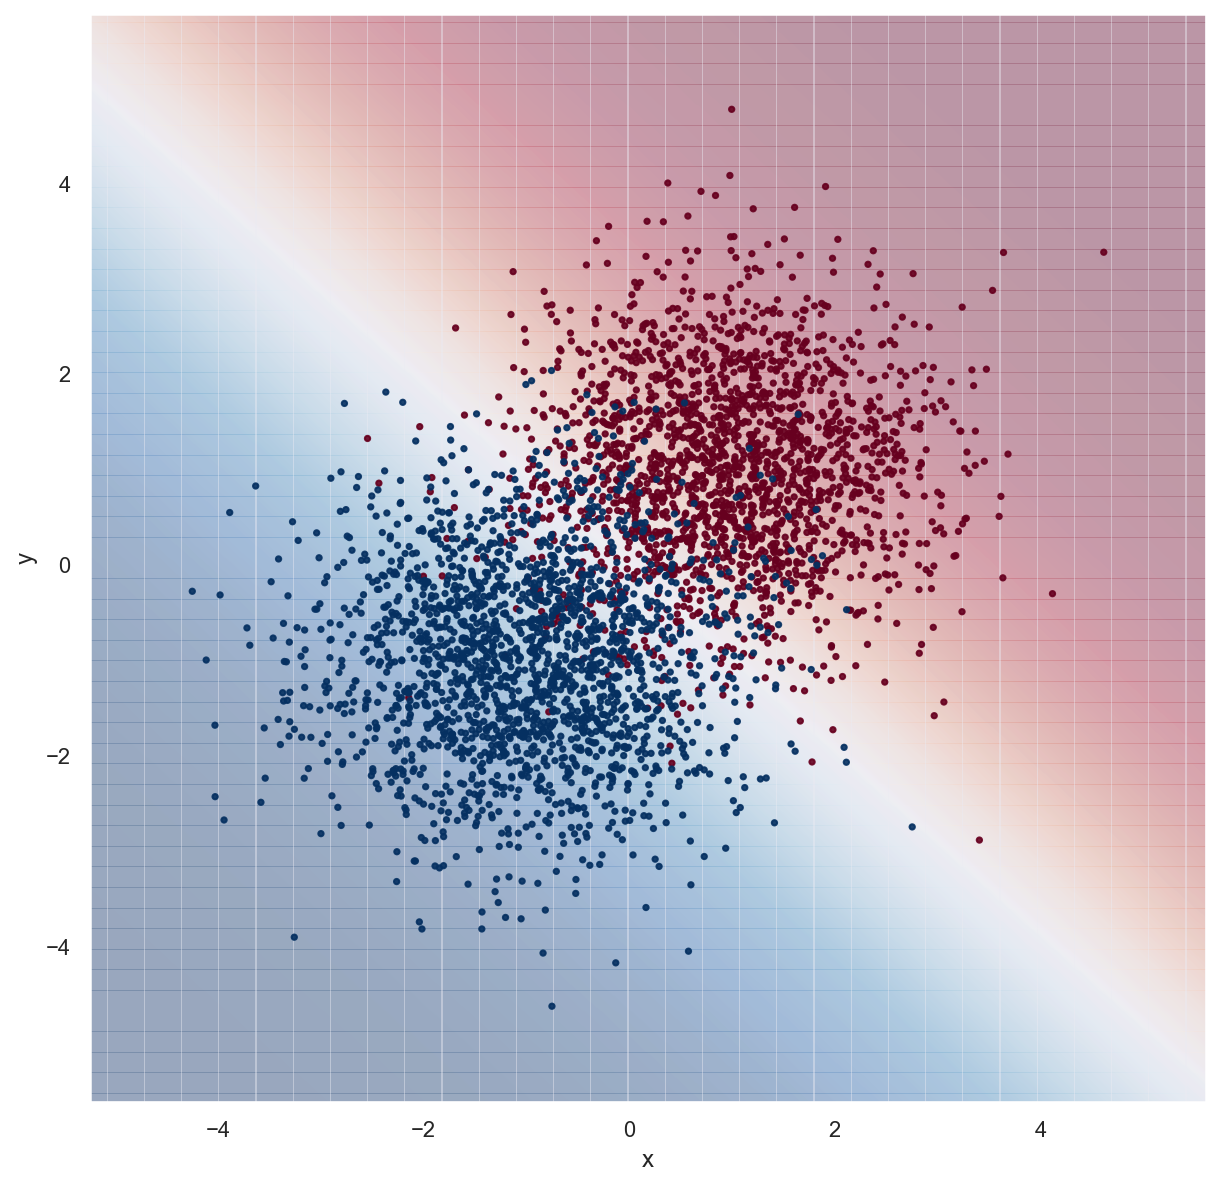

In [8]:
plot_predictions(x, y, LogisticRegression(C=0.001), proba=True)

D:\Vyacheslav\Anaconda\envs\training_pipeline\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


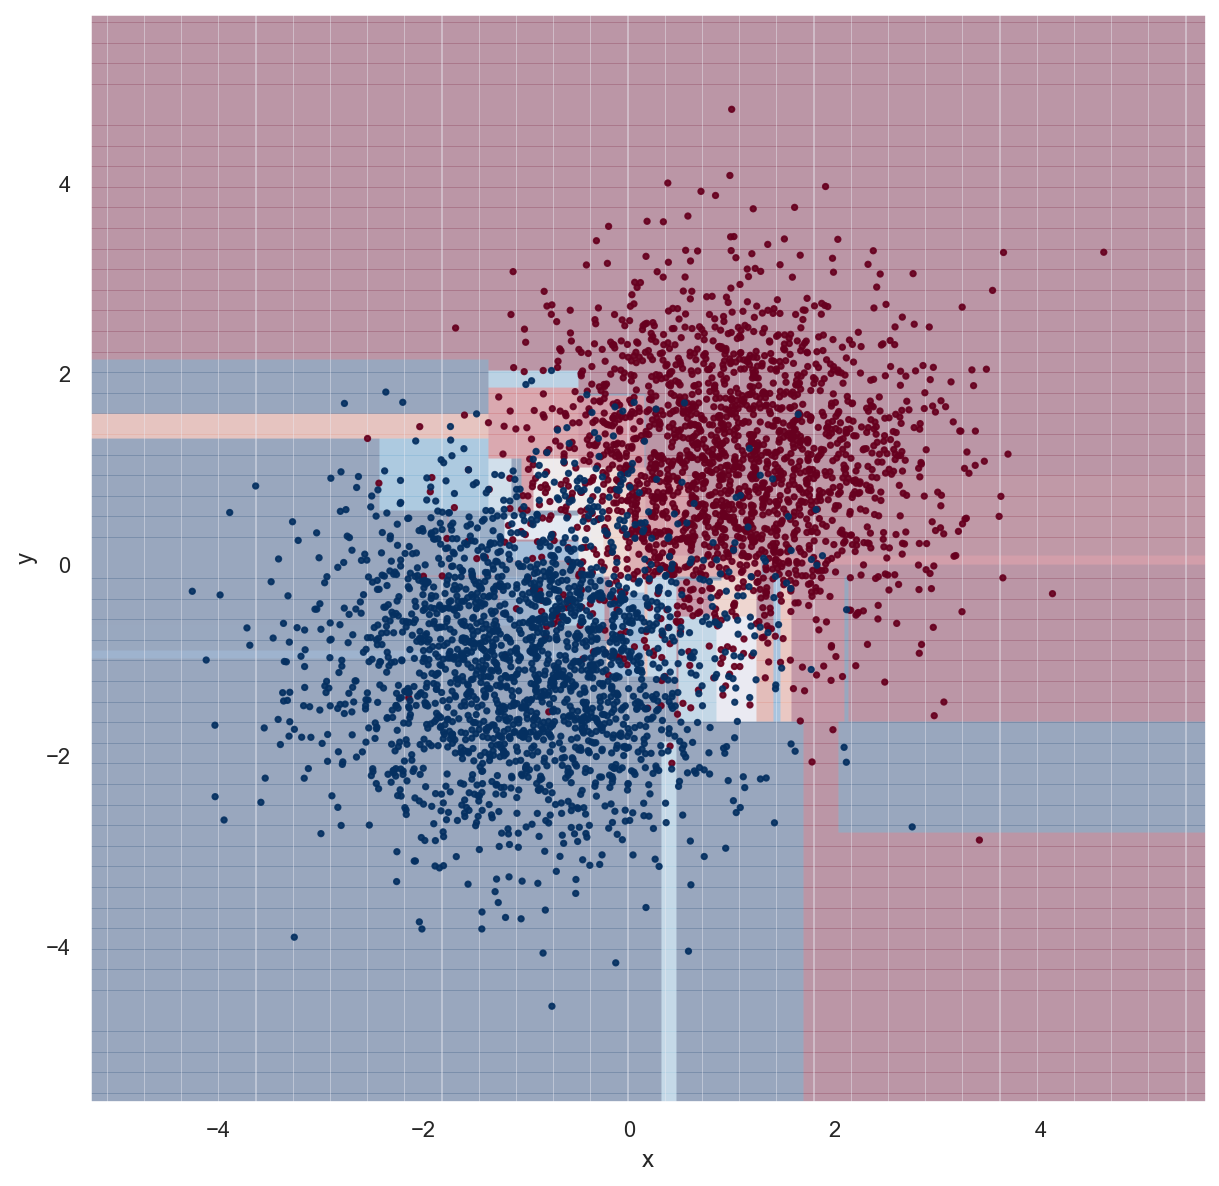

In [9]:
tree = DecisionTreeClassifier(max_depth=7)
plot_predictions(x, y, tree, proba=True);

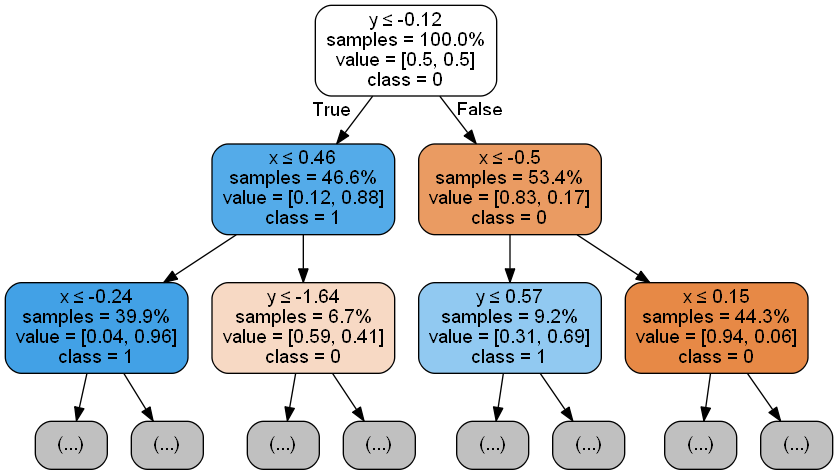

In [17]:
plot_tree(tree, ['x', 'y'], max_depth=2)

Если задать параметр `max_depth = None`, то видно что дерево переобучается: разделяющая поверхность строится на основе объектов-выбросов. Для борьбы с этим существуют несколько методов:
* ограничение структуры дерева: при построении дерево подчиняется ряду правил, например
    * ограничена максимальная высота (`max_depth`)
    * в листьях должно присутствовать как минимум какое-то число объектов (`min_samples_leaf`)
* усечение дерева: отрезание плохих вершин дерева  
Все эти методы эвристические и их качество борьбы с переобучением зависит от конкретных данных.

Рассмотрим виды деревьев, используемые на практике.  
В библиотеке CatBoost используются небрежные решающие деревья (Oblivious Trees). В них гарантированно на каждом слое дерева расположено одно и то же условие. За счет этого дерево можно представить многомерным массивом.  
<img src="./images/catboost.png" alt="Drawing" style="height: 300px;"/>
_Упражнение_: построить такое дерево.  
В библиотеке LightGBM деревья строятся в глубину. Такие деревья можно представить как связный список.  
<img src="./images/lightgbm.png" alt="Drawing" style="height: 300px;"/>
_Упражнение_: построить такое дерево.

В известной библиотеке xgBoost используется усечение. В примере ниже правое дерево является усеченной версией левого. 
<img src="./images/pruning.png" alt="Pruning" style="height: 300px;"/>

# Построение решающего дерева

Для описания алгоритма потребуется несколько определений.

__Критерий информативности__ $-$ это величина, определенная для значений из обучающей выборки, попавших в лист дерева. Говорит о том, насколько хорошо в работает предикат в этом листе. Рассмотрим некоторые из них.

*__Энтропия.__*  Это статистическая величина, измеряющая однорость данных. Низкая энтропия означает, что данные однородные, высокая $-$ что разнообразные. Она считается по следующей формуле.
 $$H(R)=\sum_{x \in X}{-p_R(x)\log_2 p_R(x)}$$
 $R$ $-$ данные  
 $X$ $-$ множество возможных значений данных  
 $p_R(x)$ $-$ частота $x$ в $R$
 
_Пример_:  
 Пусть в данных 0 встретился 1 раз, 1 встретилась 99 раз. Тогда энтропия равна
 $$H(R) = - 0.01 \cdot \log_2{0.01} - 0.99 \cdot \log_2{0.99} = 0.0808$$

Энтропия используется в задачах классификации.

*__Средняя квадратичная ошибка.__* Наша старая знакомая. В случае деревьев и задачи регрессии адаптирована: ответ в листе равен среднему ответу среди ответов обучающей выборки, попавших в лист.

$$ H(R) = \frac{1}{R} \sum_{(x_i, y_i) \in R} \Big(y_i - \frac{1}{R} \sum_{(x_j, y_j) \in R} y_j \Big)^2 $$
 
Любой алгоритм построения дерева сводится к минимизации того или иного критерия информативности. Заметим, что для любой выборки можно построить такое дерево, для которого ошибка на тренировочной выборке будет минимальна. Скорее всего такое дерево будет переобучено, поэтому следует строить деревья минимальной высоты. Найти идеальное дерево сложно, посколько для его построения требуется перебрать все возможные структуры деревьев. Поэтому обходятся жадными алгоритмами, то есть такими, которые на каждом шаге выбирают наилучшее в данный момент действие.

## Алгоритм C4.5
Этот алгоритм оперирует следующим понятием:  
*__Information Gain__* (рус. Выигрыш от ветвления, прирост информации). Условимся что для каждого признака $f$ можно получить разбиение множества $R$ на семейство непересекающихся подмножеств $\bigcup_i R_i$. Тогда:
$$IG(R, f) = H(R) - \sum_{R_i \subset R} \frac{|R_i|}{|R|} H(R_i)$$    
Другими словами, Information Gain показывает насколько выгодно разбить множество $R$ с использованием признака $f$. Подбор конкретного правила для разбиения на основе признака $f - $ отдельная задача.  
Определен для энтропийного критерия информативности.

Сам алгоритм представляет собой череду вызовов процедуры роста дерева для листьев. Процедура роста дерева выглядит так:
 1. Найти признак с наибольшим $IG$.
 2. Разделить множество объектов по этому признаку.
 3. Повторить для каждого подмножества, если его энтропия не равна нулю.  

Почитать ещё: http://www.saedsayad.com/decision_tree.htm

Попробуем сами реализовать решающее дерево. Начнем с класса `Node`, рекурсивно представляющего его структуру.

In [19]:
class Node(object):
    """
    Resembles a Node in a Decision Tree.
    self._next_left <- self.predicate -> self._next_right
    """
    def __init__(self, class_label=None):
        self._next_left = None
        self._next_right = None
        self.predicate = None

        self.class_label = class_label

    def get_class_label(self, x):
        """Recursively compute a decision for `x` based on a tree structure."""
        if self.is_leaf():
            return self.class_label

        branch = self.predicate(x)
        if branch == 0:
            return self._next_left.get_class_label(x)
        else:
            return self._next_right.get_class_label(x)
        
    def __call__(self, u):
        return self.predicate(u)
        
    def is_leaf(self):
        return self.class_label is not None
        
    def set_left(self, node):
        self._next_left = node

    def set_right(self, node):
        self._next_right = node

    def set_predicate(self, predicate):
        self.predicate = predicate

Продолжим при реализацией класса `Predicate`, представляющего решающее правило.

In [20]:
class Predicate:
    """
    Resembles a decision rule in a Decision Tree:
    self.feature > self.border
    """
    def __init__(self, x, y):
        self.border = None
        self.feature = -1

        self.split_mask = None
        self.__find_border_and_feature(x, y)

    @staticmethod
    def __entropy(labels):
        """Computes entropy for values of a given array."""
        _, counts = np.unique(labels, return_counts=True)
        frequency = counts / counts.sum()
        return np.sum(-frequency * np.log2(frequency))

    def __calculate_information_gain(self, s0, *args):
        """Calculates IG for a split s_1, ..., s_k.
           :arg s0 - the whole set
           :arg args - split, such that s0 = union(s_1, ..., s_k) and
               for all i, j: intersection(s_i, s_j) = 0
        """
        return self.__entropy(s0.reshape(len(s0))) - np.sum([
            (arg.size / float(s0.size)) * self.__entropy(arg.reshape(len(arg)))
            for arg in args
        ])

    def __find_border_and_feature(self, x, y):
        """Computes an optimal feature and its border."""
        s0 = y
        max_i_gain = 0
        for feature in np.arange(0, x.shape[1]):
            for border in x[:, feature]:
                split_mask = self.__get_split_mask(x, border, feature)
                sl, sr = self.split(x, y, split_mask)
                i_gain = self.__calculate_information_gain(s0, sl[1], sr[1])
                if i_gain > max_i_gain:
                    max_i_gain = i_gain
                    self.border = border
                    self.feature = feature
                    self.split_mask = split_mask

    def split(self, x, y, split_mask=None):
        """
        Computes a two-fold split for (x, y) using split_array as a mask.
        :args x, y - data for splitting
        :arg split_mask - binary mask for splitting, False for left fold and True for right fold
        """
        if split_mask is None:  # Using optimal split
            split_mask = self.split_mask

        left_idx = np.where(split_mask == 0)[0]
        right_idx = np.where(split_mask == 1)[0]
        return (
            [x[left_idx], y[left_idx]],
            [x[right_idx], y[right_idx]]
        )

    @staticmethod
    def __get_split_mask(x, border, feature):
        return (x[:, feature] > border).astype(np.int8)

    def __call__(self, x):
        return self.__get_split_mask(x, self.border, self.feature)

Теперь построим классификатор, последовательно строящий дерево.

In [21]:
class CustomDecisionTreeClassifier:
    """Classifies objects via a Decision Tree."""
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None

    def fit(self, x, y):
        self.root = self.__fit_id3(x, y, 1)

    def predict(self, x):
        return np.array([self.root.get_class_label(el.reshape(1, x.shape[1]))
                         for el in x], dtype=np.int8)

    def predict_proba(self, x):
        raise NotImplementedError('TODO: implement storing of class frequences'
                                  'during the search of an optimal feature and border')

    def __fit_id3(self, x, y, level):
        class_labels = np.unique(y)
        # if there is only one class in y then return leaf node
        if class_labels.size == 1:
            return Node(class_label=class_labels[0])

        # find the most informative predicate and split by them
        beta = Predicate(x, y)
        to_left, to_right = beta.split(x, y)

        # if one of arrays is empty after split then return leaf node
        if to_left[0].size == 0 or to_right[0].size == 0 or level > self.max_depth:
            labels, counts = np.unique(y, return_counts=True)
            class_label = labels[counts.argmax(axis=0)]
            return Node(class_label=class_label)

        node = Node()
        node.set_predicate(beta)

        node.set_left(self.__fit_id3(to_left[0], to_left[1], level + 1))
        node.set_right(self.__fit_id3(to_right[0], to_right[1], level + 1))

        return node

In [22]:
tree = CustomDecisionTreeClassifier(max_depth=3)

In [23]:
tree.fit(x, y)

D:\Vyacheslav\Anaconda\envs\training_pipeline\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


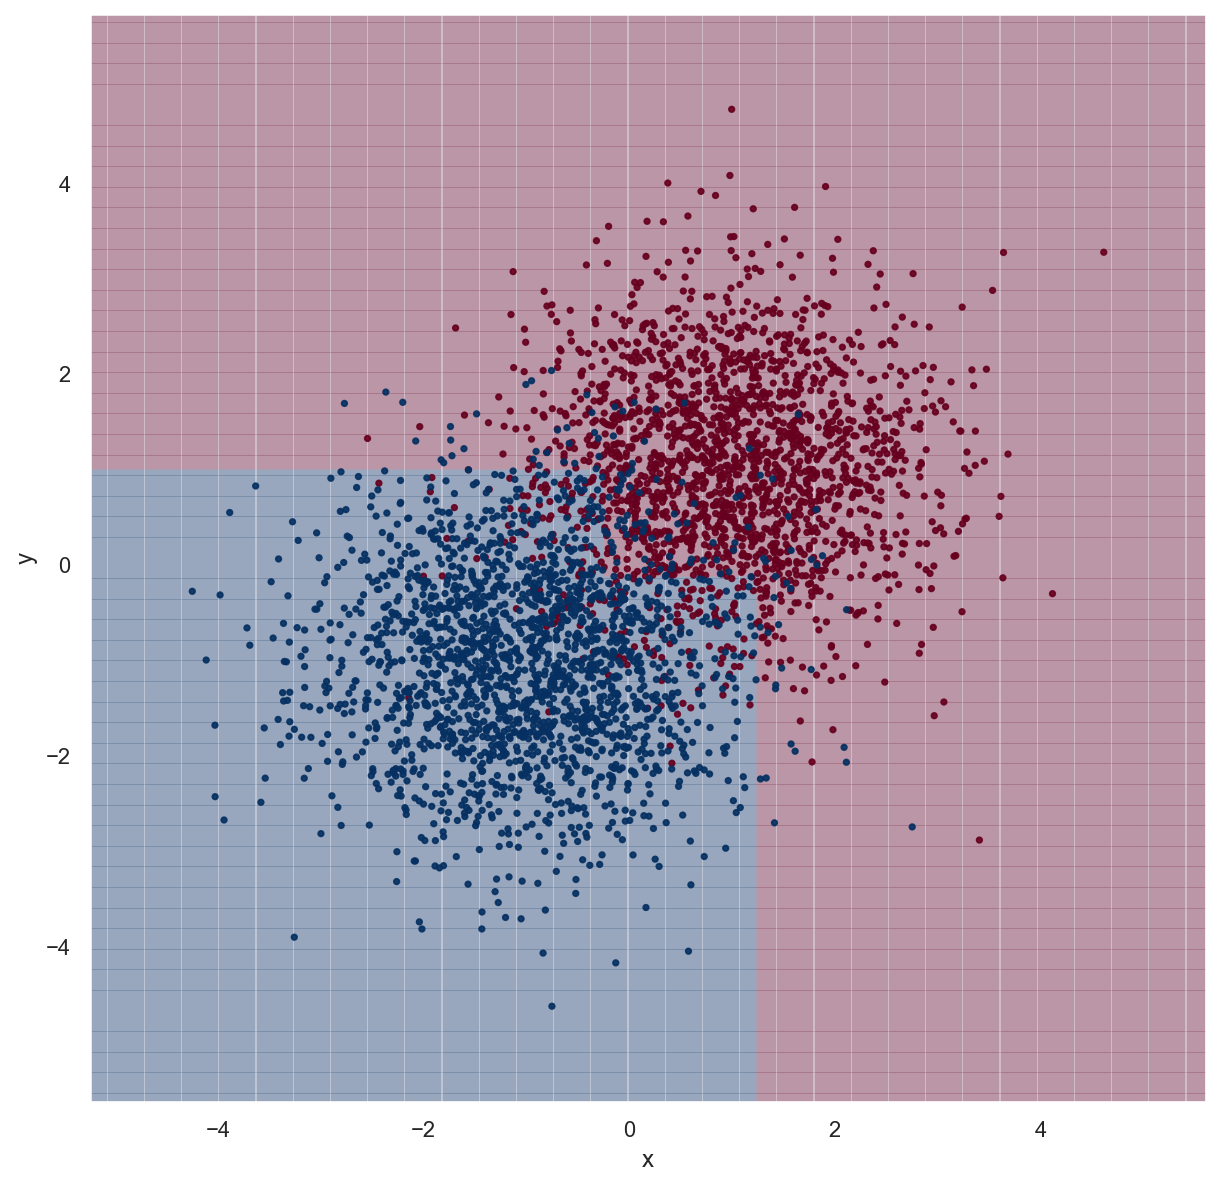

In [24]:
plot_predictions(x, y, tree);

Посмотрим на [имплементацию деревьев](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pxd) в Scikit-Learn. Для скорости они реализованы на Cython.
```python
cdef struct Node:
    # Base storage structure for the nodes in a Tree object

    SIZE_t left_child                    # id of the left child of the node
    SIZE_t right_child                   # id of the right child of the node
    SIZE_t feature                       # Feature used for splitting the node
    DOUBLE_t threshold                   # Threshold value at the node
    DOUBLE_t impurity                    # Impurity of the node (i.e., the value of the criterion)
    SIZE_t n_node_samples                # Number of samples at the node
    DOUBLE_t weighted_n_node_samples     # Weighted number of samples at the node


cdef class Tree:
    # The Tree object is a binary tree structure constructed by the
    # TreeBuilder. The tree structure is used for predictions and
    # feature importances.

    # Input/Output layout
    cdef public SIZE_t n_features        # Number of features in X
    cdef SIZE_t* n_classes               # Number of classes in y[:, k]
    cdef public SIZE_t n_outputs         # Number of outputs in y
    cdef public SIZE_t max_n_classes     # max(n_classes)

    # Inner structures: values are stored separately from node structure,
    # since size is determined at runtime.
    cdef public SIZE_t max_depth         # Max depth of the tree
    cdef public SIZE_t node_count        # Counter for node IDs
    cdef public SIZE_t capacity          # Capacity of tree, in terms of nodes
    cdef Node* nodes                     # Array of nodes
    cdef double* value                   # (capacity, n_outputs, max_n_classes) array of values
    cdef SIZE_t value_stride             # = n_outputs * max_n_classes

    # Methods
    cdef SIZE_t _add_node(self, SIZE_t parent, bint is_left, bint is_leaf,
                          SIZE_t feature, double threshold, double impurity,
                          SIZE_t n_node_samples,
                          double weighted_n_samples) nogil except -1
    cdef int _resize(self, SIZE_t capacity) nogil except -1
    cdef int _resize_c(self, SIZE_t capacity=*) nogil except -1

    cdef np.ndarray _get_value_ndarray(self)
    cdef np.ndarray _get_node_ndarray(self)

    cpdef np.ndarray predict(self, object X)

    cpdef np.ndarray apply(self, object X)
    cdef np.ndarray _apply_dense(self, object X)
    cdef np.ndarray _apply_sparse_csr(self, object X)

    cpdef object decision_path(self, object X)
    cdef object _decision_path_dense(self, object X)
    cdef object _decision_path_sparse_csr(self, object X)

    cpdef compute_feature_importances(self, normalize=*)
```
Как можем заметить, здесь деревья реализованы в классическом виде: при помощи указателей. Они могут принимать любую возможную для бинарного дерева форму.

Решающие деревья могут в том числе быть использованы для решения задачи регрессии. В таком случае они представляют собой кусочно-постоянную функцию.

In [25]:
x = np.linspace(-10, 10, num=150).reshape(-1, 1)
y = (x ** 2) * np.sin(x) + np.random.normal(scale=0.1)

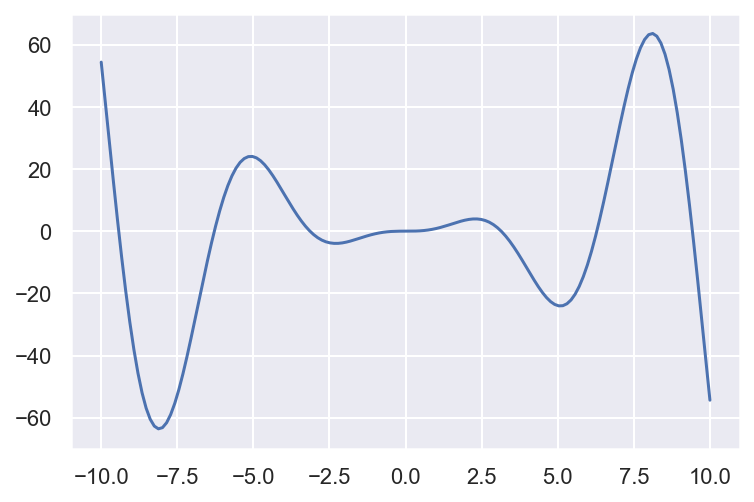

In [26]:
plt.plot(x, y);

In [27]:
def plot_regressor_as_function(reg, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)
    
    reg.fit(x_train, y_train)
    
    plt.figure(figsize=(14.0, 8.0))
    plt.plot(x_train, y_train, '.', c='C0')
    plt.plot(x_test, y_test, '.', c='C1')
    
    x_all = np.linspace(x.min(), x.max(), num=100)
    plt.plot(x_all, reg.predict(x_all.reshape(-1, 1)), c='C2')    

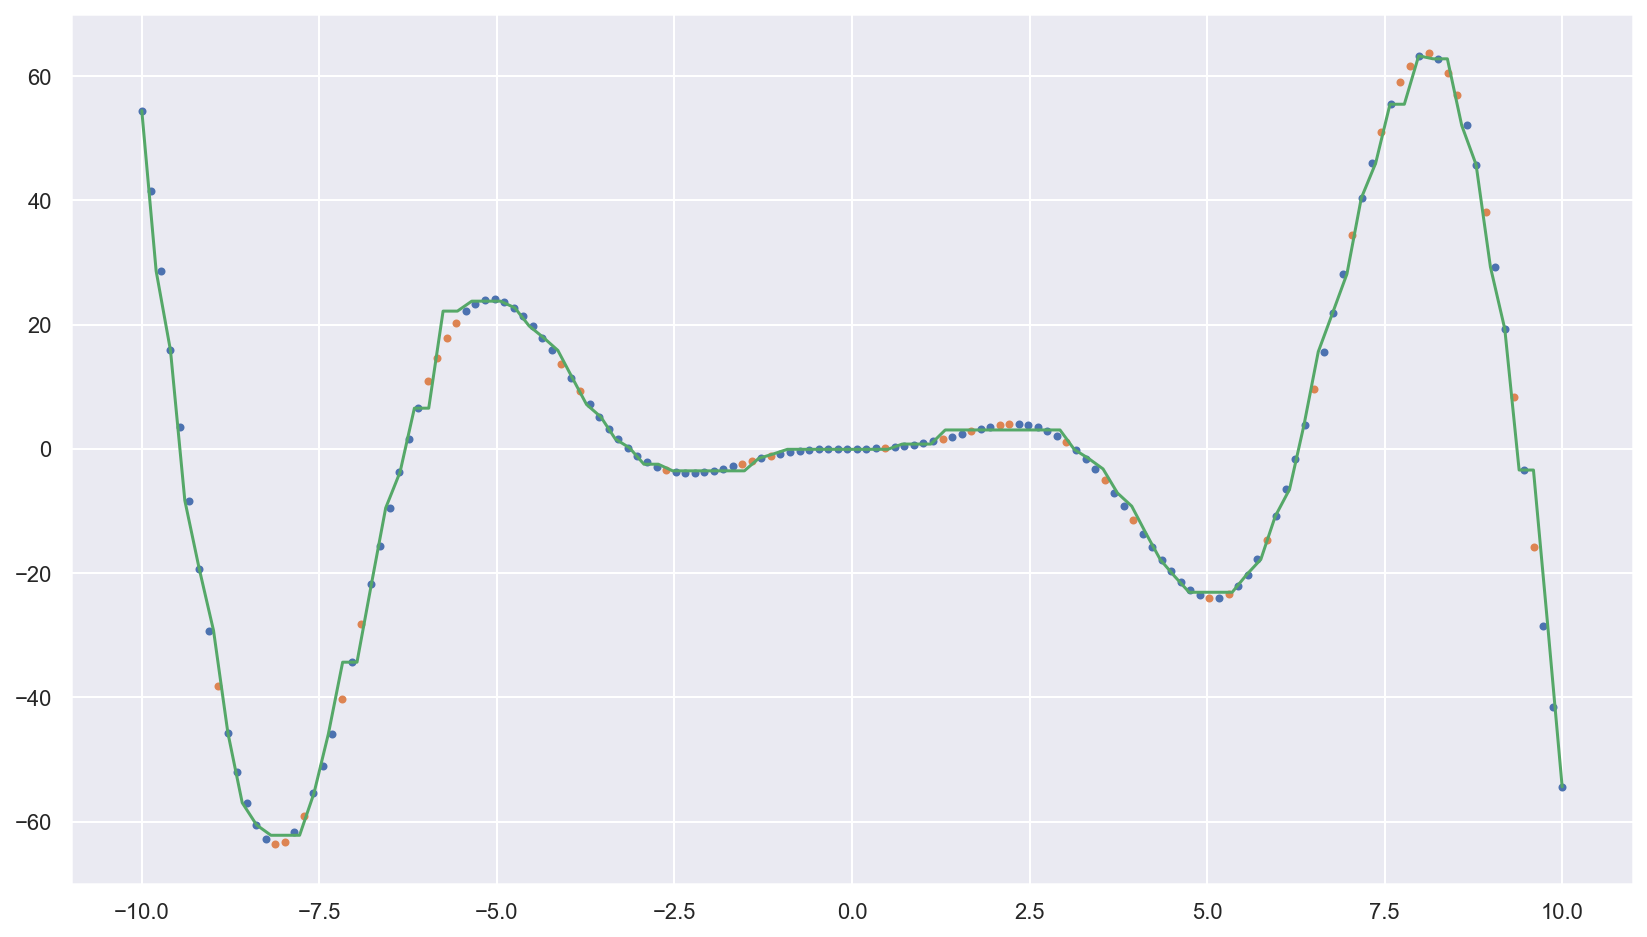

In [28]:
reg = DecisionTreeRegressor(max_depth=9)
plot_regressor_as_function(reg, x, y)

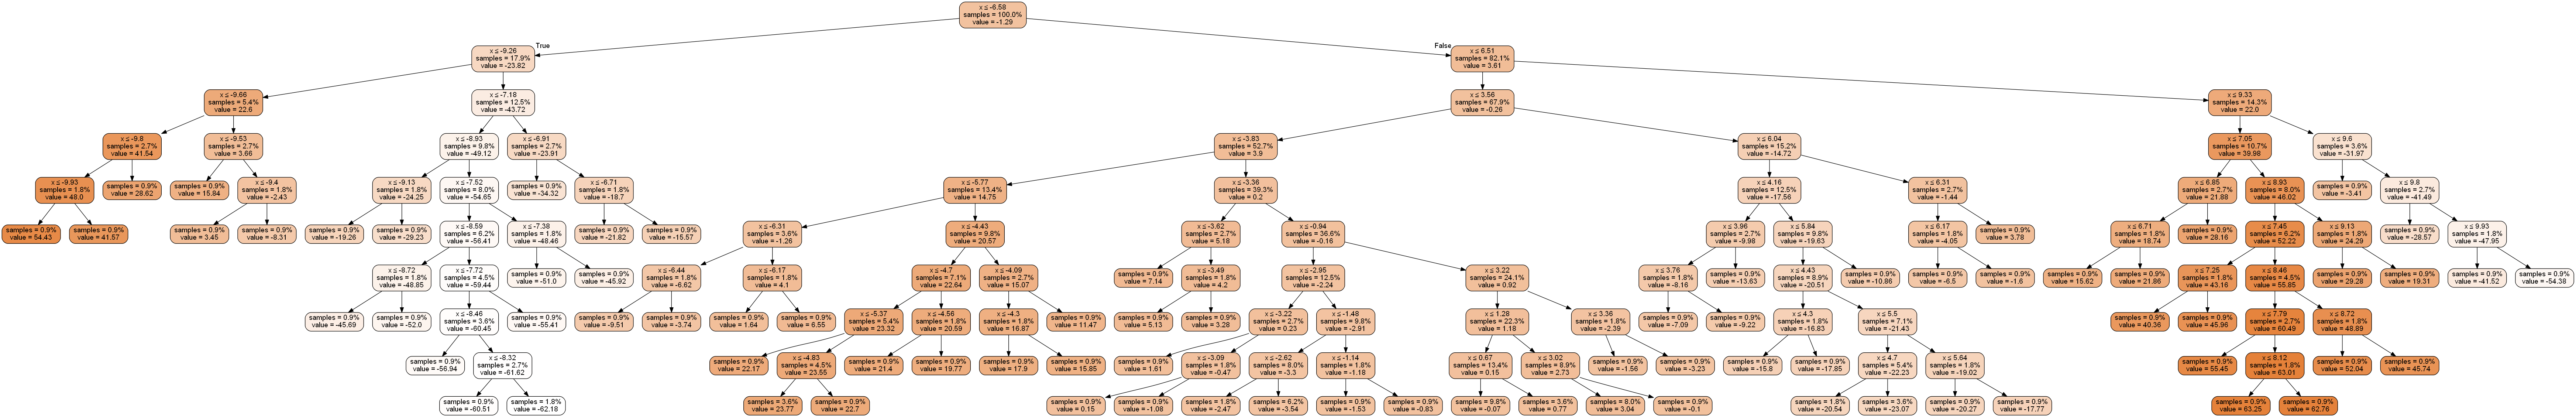

In [29]:
plot_tree(reg, ['x'], max_depth=30)

Дополнительная литература:
* Презентация Анны-Вероники Дорогуш про CatBoost, Computer Science Center: https://www.youtube.com/watch?v=UYDwhuyWYSo
* Немного описания про алгоритм построения дерева в LightGBM: https://lightgbm.readthedocs.io/en/latest/Features.html#optimization-in-accuracy
* Конспект лекции Соколова про решающие деревья: https://www.hse.ru/mirror/pubs/share/215285956